In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights


#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
def calculate_rmse_metric(y_pred,y_test):
  return np.sqrt(np.mean((y_pred - y_test)**2))

In [6]:
# In colab import files like:
datafolder = '../ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['building_id','square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [7]:
# DATA CLEANUP:
# some of the buildings in pd_educational still have bad readings 
# at the begining of the year, and I will use THRES value to take out 
# only last 8000 points of the year which would correspond to ~11 months of data
pd_edu_clean = pd.DataFrame()
all_dfs = []
THRES = 8000 
for bldg_id in pd_educational.building_id.unique():
    building = pd_educational[pd_educational.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      all_dfs.append(pd_educational[pd_educational.building_id == bldg_id][-THRES:])
pd_edu_clean = pd.concat(all_dfs)

# DATA NORMALIZATION:
# Normalize only numeric columns using only data that will be used for training
# Test data will be data from month of December 2016, and training data is the data 
# from begining of the 2016 up to December:
features_norm = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_help = pd_edu_clean.copy()
pd_train = pd_help.loc[pd.to_datetime(pd_help["timestamp"]) < datetime.datetime(2016, 12, 1)]
train_mean = pd_train[features_norm].mean()
train_std = pd_train[features_norm].std()

pd_edu_clean[features_norm] = (pd_edu_clean[features_norm] - train_mean)/train_std

In [8]:
# Use December as a test data and rest of the months are training:
test_size = 24*31 - 1
def prepare_for_LSTM_with_memory(pd, input_features, target, days_in = 1):
  days_in_points = days_in*24
  features_per_sample_train = []
  target_per_sample_train = []
  features_per_sample_test = []
  target_per_sample_test = []
  all_features = input_features.copy()
  all_features.extend(target)
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    features_per_sample = []
    target_per_sample = []
    for i in range(len(building.timestamp)- days_in_points):
      features_per_sample.append(np.array(np.float32(building[all_features][i:i+days_in_points])))
      target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
    features_per_sample_train.extend(features_per_sample[:-test_size])
    features_per_sample_test.extend(features_per_sample[-test_size:])
    target_per_sample_train.extend(target_per_sample[:-test_size])
    target_per_sample_test.extend(target_per_sample[-test_size:])
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [9]:
# Names of columns for input features we will use for leaning as well as target feature 
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
target = ['meter_reading']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_memory(pd_edu_clean,input_features,target,days_in=1)

# Plain LSTM Model

In [10]:
num_features = train_x.shape[2]
timesteps = train_x.shape[1]
# Let's make a model:
lstm_model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=200, activation='relu', # units is the number of hidden states
          input_shape = (timesteps, num_features),
          return_sequences = True) ,
      tf.keras.layers.Dense(200) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [11]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 200)           169600    
                                                                 
 dense (Dense)               (None, 24, 200)           40200     
                                                                 
 dense_1 (Dense)             (None, 24, 1)             201       
                                                                 
Total params: 210,001
Trainable params: 210,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model
history = lstm_model.fit(train_x, train_y, 
                         batch_size = 1024,
          epochs=10, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/10
672/672 [==============================] - 323s 477ms/step - loss: 0.1840 - mean_squared_error: 0.1840
Epoch 2/10
672/672 [==============================] - 326s 486ms/step - loss: 0.0743 - mean_squared_error: 0.0743
Epoch 3/10
672/672 [==============================] - 3128s 5s/step - loss: 0.0529 - mean_squared_error: 0.0529
Epoch 4/10
672/672 [==============================] - 326s 486ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 5/10
672/672 [==============================] - 326s 485ms/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 6/10
672/672 [==============================] - 327s 487ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 7/10
672/672 [==============================] - 331s 493ms/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 8/10
672/672 [==============================] - 404s 601ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 9/10
672/672 [==============================] - 367s 546ms/step - loss: 0.0334 - mea

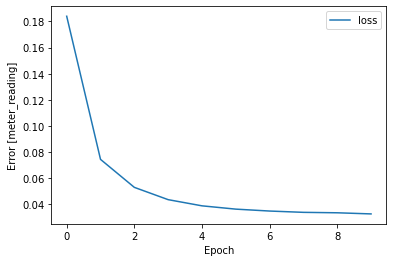

In [13]:
# plot loss history
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

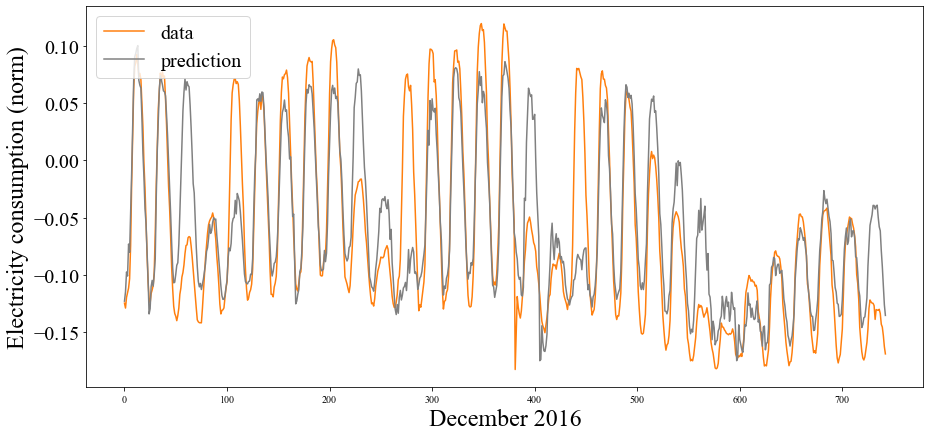

In [14]:
# Use lSTM model to make prediction 1 hour in advance
y_hat_lstm = lstm_model.predict(test_x)
y_hat_last = y_hat_lstm[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

In [15]:
# rmse for 1 hour
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.04656184

In [14]:
# Make prediction 12 hour in advance
# make function make prediction:
def make_prediction(test_x, model,n_ahead):
  yhat = []
  X = test_x.copy()
  for _ in range(n_ahead):
    fc = model.predict(X)
    yhat.append(fc[:,0,0])

    helper_X = X[:,:,3]
    for sample in range(0,X.shape[0],n_ahead):
      for idx in range(23):
        X[sample,idx,3] = helper_X[sample,idx+1]
      X[sample,-1,3] = fc[sample,0,0]
  yhat = np.array(yhat)
  newarr1 = np.array_split(yhat[:,:], 95, axis = 1) # for 95 buildings we have
  all_blds = np.mean(newarr1,axis = 0)

  yhat_tot = []
  for i in range(0,all_blds.shape[1],n_ahead):
    yhat_tot.extend(all_blds[:,i])

  return np.array(yhat_tot)

In [15]:
yhat_tot = make_prediction(test_x, lstm_model,n_ahead = 12)
yhat_tot.shape

(744,)

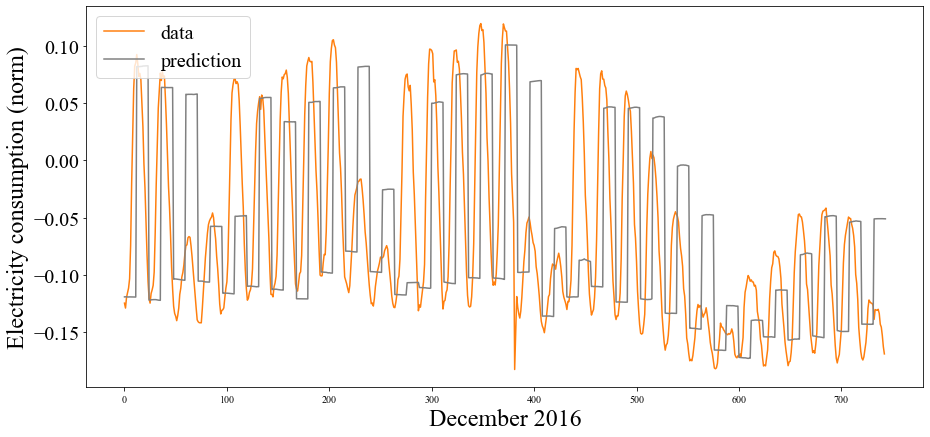

In [16]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

In [17]:
# RMSE for 12 hour
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.09078829

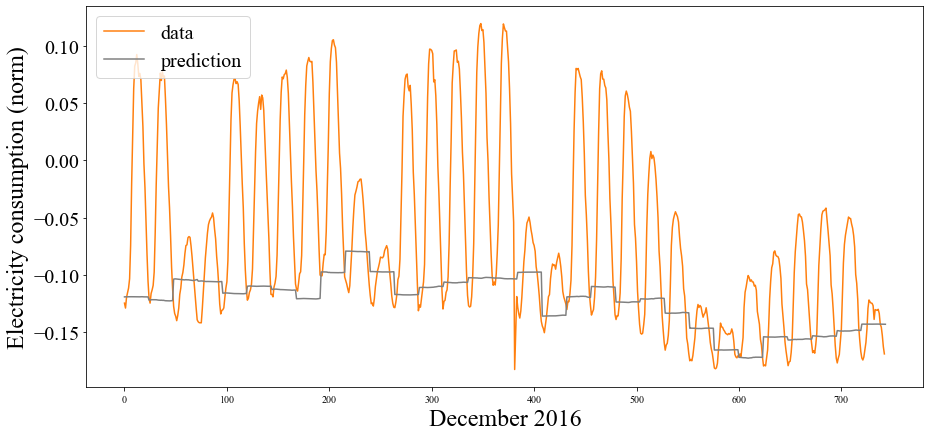

In [18]:
# Make prediction 24 hour in advance
yhat_tot = make_prediction(test_x, lstm_model,n_ahead = 24)
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

In [19]:
# rmse for 24 hour
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.09359694